<div style="display: flex; background-color: RGB(100,100,100);" >
  <h1 style="margin: auto; padding: 20px; "> Projet: ANALYSE DES VENTES D'UNE LIBRAIRIES! </h1>
</div>

### Sommaire
###  <a href="#AF"> 1. Analyse de la forme des fichiers et regularisation en vu des prochaines analyses </a>
###  <a href="#F"> 2. Analyse des indicateurs de ventes </a>
###  <a href="#FA"> 3. Analyse bivariee et tests statistiques </a>

## Mission du projet

<div style="border: 1px solid RGB(100,100,100);" >
    Lapage a un site de vente en ligne depuis 2 ans et ajourd'hui, on souhaite pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc. Afin de décider par exemple si nous devons créer certaines offres, adapter certains prix, etc. Cette analyse va être découpée en deux parties:
    <ul>
        <li> Une analyse des différents indicateurs de vente (Différents indicateurs et graphiques autour du
chiffre d'affaires. Evolution dans le temps du CA et mise en place d'une décomposition en moyenne mobile pour évaluer la tendance globale, faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.) ; </li>
        <li> Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne (le lien entre le genre d’un client et les catégories des livres achetés ; et ensuite le lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et les catégories des livres achetés.) </li>
    </ul>
</div>

<div style="border: 1px solid RGB(100,100,100);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> <a id="AF"> 1 - Analyse de la forme des fichiers et regularisation en vu des prochaines analyses </a></h3>
</div>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
import scipy
import statsmodels.api as sm
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from scipy.stats import pearsonr

In [2]:
# Importation des fichiers csv sous forme de dataframes
customer = pd.read_csv('customers.csv')
product = pd.read_csv('products.csv')
transaction = pd.read_csv('transactions.csv')

### Exploration du fichier des clients

In [3]:
display(customer.head())
display(customer.dtypes)
display(customer.shape)
display(customer.isna().sum())
display(customer.nunique())
display(customer.describe())

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


client_id    object
sex          object
birth         int64
dtype: object

(8623, 3)

client_id    0
sex          0
birth        0
dtype: int64

client_id    8623
sex             2
birth          76
dtype: int64

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


#### Observation:
* On compte 8623 clients carracterises par le sex et la date de naissance ;
* Type variable attendu ;
* Aucune valeur manquante ; 
* Aucune valeur aberrante.


client_id => Primary Key

### Exploration du fichier des produits

In [4]:
display(product.head())
display(product.dtypes)
display(product.shape)
display(product.isna().sum())
display(product.nunique())
display(product.describe())

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


id_prod     object
price      float64
categ        int64
dtype: object

(3287, 3)

id_prod    0
price      0
categ      0
dtype: int64

id_prod    3287
price      1455
categ         3
dtype: int64

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


#### Observation:
* Le fichier comporte 3287 produits avec le prix unitaire et la categorie associee (3) ;
* Type variable attendu, pour faciliter les analyses, convertir 'categ' en object ;
* Aucune valeur manquante ;
* Valeurs aberrantes sur prix; prix minimum (-1), piste à explorer ;
* Trois valeurs uniques pour 'catégories' ;
* A première vue, le premier chiffre de 'id_prod' correspond à la 'catégorie', théorie à vérifier.


id_prod => Primary Key

In [5]:
# Convertir variable 'categ' en string
product['categ'] = product['categ'].astype(str)
# Chercher les produits dont le prix est 0 ou moins
product.loc[product['price']<=0]

,id_prod,price,categ
731,T_0,-1.0,0


### Exploration du fichier des transaction(commandes)

In [6]:
display(transaction.head())
display(transaction.dtypes)
display(transaction.shape)
display(transaction.isna().sum())
display(transaction.nunique())
display(transaction.describe())

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


id_prod       object
date          object
session_id    object
client_id     object
dtype: object

(679532, 4)

id_prod       0
date          0
session_id    0
client_id     0
dtype: int64

id_prod         3267
date          679371
session_id    342316
client_id       8602
dtype: int64

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


#### Observation:
* Variable 'date' de mauvais type
* Aucune valeurs manquante
* Nombre de valeurs uniques pour 'date' et 'cession' étranges, aucun ne correspond au nombre de lignes total de la dataframe. Indique des doublons. 

#### Action à prendre: 
* Vérifier variable 'date'
* Explorer les variables 'date' et 'session_id'

In [7]:
# Lignes contenant 'test' dans variable 'date'
test = transaction.loc[transaction['date'].str.contains('test')].sort_values('date')
display(test)
display(test.nunique())

,id_prod,date,session_id,client_id
96687,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
453857,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
91133,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
607892,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_0
548383,T_0,test_2021-03-01 02:30:02.237412,s_0,ct_1
...,...,...,...,...
392443,T_0,test_2021-03-01 02:30:02.237448,s_0,ct_0
19312,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
573155,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0


id_prod        1
date          39
session_id     1
client_id      2
dtype: int64

#### Observation:
Tous les tests ont été faits le même jours à des fractions de seconde d'intervalles et ce sont les premières transactions faites sur le même 'session_id'. 
Ces transactions sont les ventes du même produit (T_0) qui correspondent au produit donc le prix est à -1 qu'on avait vu pendant le nettoyage de la dataframe 'produit'.
Nous observons que ces transaction sont faîtes par seulement deux clients (ct_0 et ct_1) .  

Ce sont sûrement des tests que l'entreprise a fait pour vérifier le fonctionnement du site. 
Ct qui pourrait indiquer 'client test', T_0 qui pourrait indiquer Produit test. 


In [8]:
# Filtrage des donnees correspondant aux tests effectues
product_test = product['id_prod'].str.contains('T')
customer_test = customer['client_id'].str.contains('ct')
transaction_test = transaction['date'].str.contains('test')

In [9]:
# Copie des donnees sauf les donnees correspondant aux tests
transaction = transaction.loc[~transaction_test].copy()
product = product.loc[~product_test].copy()
customer = customer.loc[~customer_test].copy()

In [10]:
# Conversion variable 'date' en type date. 
transaction['date'] = pd.to_datetime(transaction['date'])

In [11]:
# Vérification des changements sur le dataframe des transactions
display(transaction.head())
display(transaction.shape)
display(transaction.dtypes)
display(transaction.nunique())

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


(679332, 4)

id_prod               object
date          datetime64[ns]
session_id            object
client_id             object
dtype: object

id_prod         3266
date          679332
session_id    342315
client_id       8600
dtype: int64

### Fusion des dataframes
#### Customer et transaction

In [12]:
# Outter merge des dataframes customers et transaction
custo_trans = pd.merge(customer, transaction, on='client_id', how='outer', indicator=True )
display(custo_trans['_merge'].unique())
display(custo_trans.shape)
display(custo_trans.head())

['both', 'left_only']
Categories (3, object): ['left_only', 'right_only', 'both']

(679353, 7)

,client_id,sex,birth,id_prod,date,session_id,_merge
0,c_4410,f,1967,0_1316,2021-12-29 09:11:18.860592,s_141762,both
1,c_4410,f,1967,1_385,2021-03-22 01:40:22.782925,s_9707,both
2,c_4410,f,1967,1_190,2021-11-12 18:11:43.280574,s_118628,both
3,c_4410,f,1967,0_1455,2021-03-22 14:29:25.189266,s_9942,both
4,c_4410,f,1967,1_483,2022-03-13 21:35:55.949042,s_178686,both


**Observation**: 
Certains 'client_id' sont dans la dataframe 'customer' mais pas dans la dataframe 'transaction', ce qui veut dire que nous avions des clients qui n'ont pas fait de transactions.

#### Produit et transaction

In [13]:
# Outter merge des dataframe produit et transaction
product_trans = pd.merge(transaction, product, on='id_prod', how='outer', indicator=True )
display(product_trans['_merge'].unique())
display(product_trans.shape)
display(product_trans.head())

['both', 'left_only', 'right_only']
Categories (3, object): ['left_only', 'right_only', 'both']

(679353, 7)

,id_prod,date,session_id,client_id,price,categ,_merge
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,both
1,0_1518,2021-09-26 12:37:29.780414,s_95811,c_6197,4.18,0,both
2,0_1518,2021-05-06 17:14:43.117440,s_30782,c_682,4.18,0,both
3,0_1518,2022-03-16 18:57:10.420103,s_180057,c_5932,4.18,0,both
4,0_1518,2022-11-12 18:58:10.574853,s_296584,c_7217,4.18,0,both


In [14]:
# Produit qui sont dans dataframe'transaction' mais pas dans dataframe 'produit'
left_only = product_trans.loc[product_trans['_merge']=='left_only']
display(left_only['id_prod'].unique())
display(left_only.shape)
display(left_only)

array(['0_2245'], dtype=object)

(221, 7)

,id_prod,date,session_id,client_id,price,categ,_merge
542560,0_2245,2022-09-23 07:22:38.636773,s_272266,c_4746,NaN,NaN,left_only
542561,0_2245,2022-07-23 09:24:14.133889,s_242482,c_6713,NaN,NaN,left_only
542562,0_2245,2022-12-03 03:26:35.696673,s_306338,c_5108,NaN,NaN,left_only
542563,0_2245,2021-08-16 11:33:25.481411,s_76493,c_1391,NaN,NaN,left_only
542564,0_2245,2022-07-16 05:53:01.627491,s_239078,c_7954,NaN,NaN,left_only
...,...,...,...,...,...,...,...
542776,0_2245,2021-08-25 09:06:03.504061,s_80395,c_131,NaN,NaN,left_only
542777,0_2245,2022-03-06 19:59:19.462288,s_175311,c_4167,NaN,NaN,left_only
542778,0_2245,2022-05-16 11:35:20.319501,s_209381,c_4453,NaN,NaN,left_only
542779,0_2245,2022-02-11 09:05:43.952857,s_163405,c_1098,NaN,NaN,left_only


**Observation**: 
Le produit '0_2245' a été vendu mais il n'est pas présent dans la dataframe 'produit', donc nous n'avions pas les information sur ce produit, il faudrait trouver ces information car il a été vendu 221 fois ce qui pourrait avoir une grande influence sur l'analyse.

In [15]:
# Calculer le prix moyen des articles de catégorie '0'
product_cat_0 = product.loc[product['categ']=='0']
moyen_price_cat_0 = product_cat_0['price'].mean()
# Ajouter une nouvelle ligne à la dataframe 'product' contenant les information du produit '0_2245'
product.loc[-1] = ['0_2245',moyen_price_cat_0,'0']
product.reset_index(drop=True)

,id_prod,price,categ
0,0_1421,19.990000,0
1,0_1368,5.130000,0
2,0_731,17.990000,0
3,1_587,4.990000,1
4,0_1507,3.990000,0
...,...,...,...
3282,0_146,17.140000,0
3283,0_802,11.220000,0
3284,1_140,38.560000,1
3285,0_1920,25.160000,0


In [16]:
# Produit qui sont dans dataframe'produit' mais pas dans dataframe 'transaction'
right_only = product_trans.loc[product_trans['_merge']=='right_only']
display(right_only)
display(right_only.shape)

,id_prod,date,session_id,client_id,price,categ,_merge
679332,0_1016,NaT,NaN,NaN,35.06,0,right_only
679333,0_1780,NaT,NaN,NaN,1.67,0,right_only
679334,0_1062,NaT,NaN,NaN,20.08,0,right_only
679335,0_1119,NaT,NaN,NaN,2.99,0,right_only
679336,0_1014,NaT,NaN,NaN,1.15,0,right_only
679337,1_0,NaT,NaN,NaN,31.82,1,right_only
679338,0_1318,NaT,NaN,NaN,20.92,0,right_only
679339,0_1800,NaT,NaN,NaN,22.05,0,right_only
679340,0_1645,NaT,NaN,NaN,2.99,0,right_only
679341,0_322,NaT,NaN,NaN,2.99,0,right_only


(21, 7)

**Observervation**: 
Nous avons 21 produits qui n'ont pas été vendus, avec des prix très variables. Ce serait judicieux de faire une promotion sur ces produits.

### Jointure interne des trois dataframes

In [18]:
# Inner merge des dataframes 'customer', 'transaction' et product
df = pd.merge( (pd.merge(customer, transaction, on='client_id')), product, on='id_prod' )
df.head()

,client_id,sex,birth,id_prod,date,session_id,price,categ
0,c_4410,f,1967,0_1316,2021-12-29 09:11:18.860592,s_141762,7.2,0
1,c_4410,f,1967,0_1316,2022-03-29 09:11:18.860592,s_186233,7.2,0
2,c_4410,f,1967,0_1316,2022-05-29 09:11:18.860592,s_215758,7.2,0
3,c_3654,f,1978,0_1316,2021-11-26 03:51:34.068872,s_125143,7.2,0
4,c_3654,f,1978,0_1316,2022-08-26 03:51:34.068872,s_258546,7.2,0


In [19]:
# Création de la variable 'age'

df['age']= (pd.DatetimeIndex(df['date']).year)-df['birth']

In [20]:
df.to_csv('df.csv')
display(df.nunique())
display(df.dtypes)
display(df)

client_id       8600
sex                2
birth             76
id_prod         3266
date          679332
session_id    342315
price           1443
categ              3
age               78
dtype: int64

client_id             object
sex                   object
birth                  int64
id_prod               object
date          datetime64[ns]
session_id            object
price                float64
categ                 object
age                    int64
dtype: object

,client_id,sex,birth,id_prod,date,session_id,price,categ,age
0,c_4410,f,1967,0_1316,2021-12-29 09:11:18.860592,s_141762,7.20,0,54
1,c_4410,f,1967,0_1316,2022-03-29 09:11:18.860592,s_186233,7.20,0,55
2,c_4410,f,1967,0_1316,2022-05-29 09:11:18.860592,s_215758,7.20,0,55
3,c_3654,f,1978,0_1316,2021-11-26 03:51:34.068872,s_125143,7.20,0,43
4,c_3654,f,1978,0_1316,2022-08-26 03:51:34.068872,s_258546,7.20,0,44
...,...,...,...,...,...,...,...,...,...
679327,c_8138,f,1984,0_394,2021-11-09 09:02:38.299240,s_116986,2.14,0,37
679328,c_8138,f,1984,0_394,2022-08-09 09:02:38.299240,s_250653,2.14,0,38
679329,c_8138,f,1984,0_394,2022-03-09 09:02:38.299240,s_176587,2.14,0,38
679330,c_8327,m,1972,0_394,2022-06-28 22:44:11.200205,s_230707,2.14,0,50


<div style="border: 1px solid RGB(100,100,100);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> <a id="F"> 2 - Analyse des indicateurs de ventes</a></h3>
</div>

In [21]:
# Déclarer fonction pour les differents tests

# Tester si un échantillon suis une distribution normale.
#(Les tests de Normalité seront faits en utilisant un test de Kolmogoroc-Smirnov, à cause de la grande taille des échantillons)
def TestNormalité(p_value):
    if p_value > 0.05: 
         print(f" Nous pouvons estimer que l'échantillon a une distribution Normale")
    else :
         print(f" Nous pouvons estimer que l'échantillon ne suit pas une distribution Normale")

# Tester la variance entre échantillon
#(Les test de variance seront faits en utilisant un test de Bartlett )
def TestVariance(p_value):
    if p_value > 0.05: 
        print(f" La variance est égale entre les deux échantillons")
    else :
        print(f" La variance des échantillons n'est pas égale")

# Interprétation du p-value
def TestStat(p_value):
    if p_value > 0.05: 
        print(f" L'hypothèse null (H0) peut être acceptée")
    else :
        print(f" L'hypothèse null (H0) est rejetée")

### Indicateurs et graphiques sur le CA

In [22]:
# CA total
ca_total = df['price'].sum()
display(ca_total)

11856321.627612649

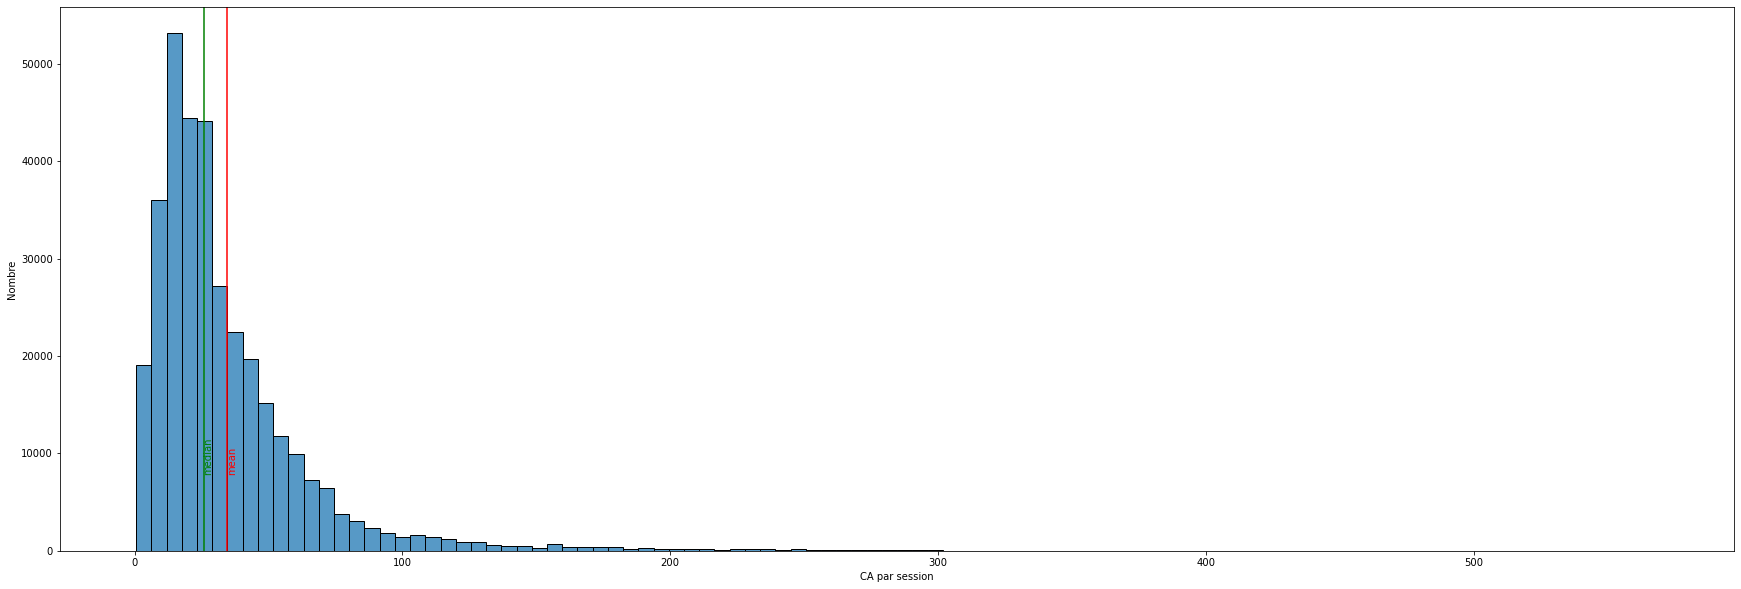

In [52]:
# Indicateur du CA par session
df_session = df.groupby('session_id',as_index=False).agg( client_id=('client_id','min'),
                                                         genre=('sex','min'),
                                                         age=('age','min'),
                                                         date_transaction=('date','min'),
                                                         ca=('price','sum') )
plt.figure(figsize=(30,10))
sns.histplot(data=df_session['ca'],bins=100)
mean = df_session['ca'].mean()
plt.axvline(x=mean, color='red')
plt.text(mean, 8000, 'mean', rotation=90, color='red')
median=df_session['ca'].median()
plt.axvline(x=median, color='green')
plt.text(median, 8000, 'median', rotation=90, color='green')
plt.xlabel('CA par session')
plt.ylabel('Nombre')
plt.show()

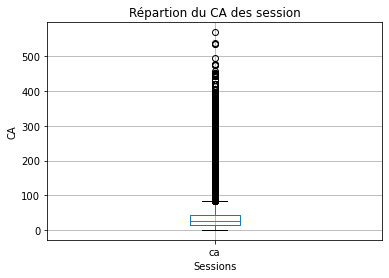

In [56]:
# Répartition du CA par session sous forme de boxplot
df_session.boxplot('ca')
plt.title('Répartion du CA des session')
plt.xlabel('Sessions')
plt.ylabel('CA')

plt.show()

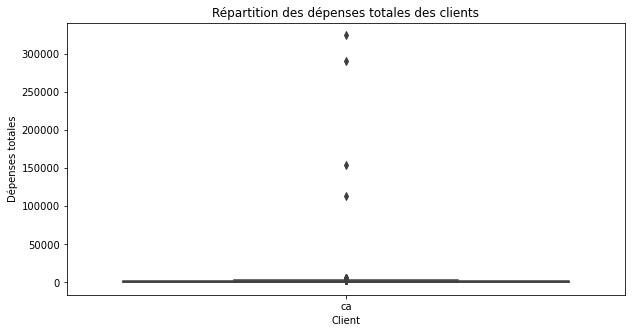

In [66]:
# Indicateur du CA par client
df_ca_client = df_session.groupby('client_id', as_index=False)['ca'].sum()
plt.figure(figsize=(10,5))
sns.boxplot(data=df_ca_client)
plt.xlabel('Client')
plt.ylabel('Dépenses totales')
plt.title( 'Répartition des dépenses totales des clients')
plt.show()

**Observation**: 
Nous observons qu'il y a 4 outliers, qui dépensent beaucoup plus que la majorité des autres clients. Ce pourrait être des clients professionnels, qui ne reflètent donc pas le comportement d'un client lambda.

In [71]:
# Filtrage des 4 outliers
outliers = df_ca_client[df_ca_client['ca']>50000]
client_id_outliers = outliers['client_id']

In [72]:
client_id_outliers

677     c_1609
2724    c_3454
4388    c_4958
6337    c_6714
Name: client_id, dtype: object

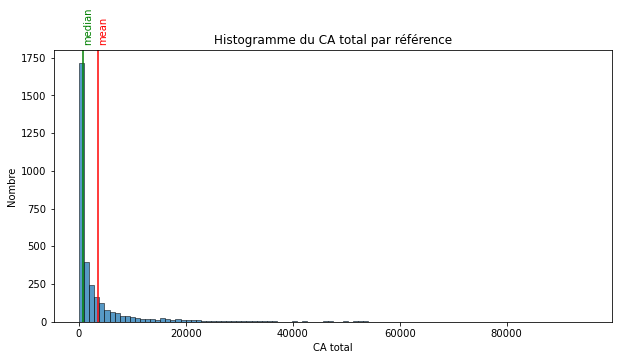

In [75]:
# Indicateur du CA par références
df_ca_product = df.groupby('id_prod', as_index=False)['price'].sum()

plt.figure(figsize=(10,5))
sns.histplot(data=df_ca_product['price'],bins=100)
mean = df_ca_product['price'].mean()
plt.axvline(x=mean, color='red')
plt.text(mean, 1850, 'mean', rotation=90, color='red')
median=df_ca_product['price'].median()
plt.axvline(x=median, color='green')
plt.text(median, 1850, 'median', rotation=90, color='green')
plt.title('Histogramme du CA total par référence')
plt.xlabel('CA total')
plt.ylabel('Nombre')
plt.show()

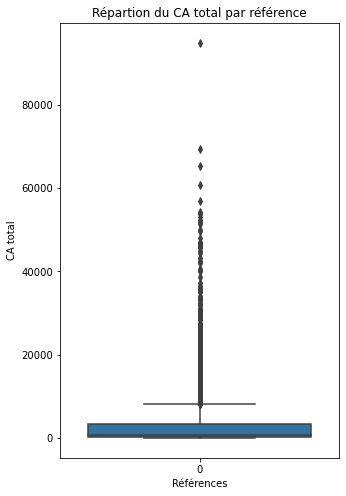

In [76]:
# Répartition du CA total par référence
plt.figure(figsize=(5,8))
sns.boxplot(data=df_ca_product['price'])
plt.title('Répartion du CA total par référence')
plt.xlabel('Références')
plt.ylabel('CA total')
plt.show()

### Indicateurs et graphiques sur la variable 'age'

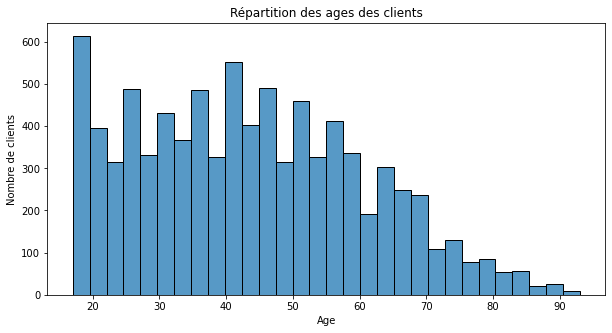

In [77]:
# Indicateur de 'age' par client
age_size = (df_session.groupby(['client_id'], as_index=False)['age'].median())
age_size
plt.figure(figsize=(10,5))
sns.histplot(data=age_size['age'])
plt.xlabel('Age')
plt.ylabel('Nombre de clients')
plt.title('Répartition des ages des clients')
plt.show()

### CA dans le temps

<AxesSubplot:>

count      730.000000
mean     16241.536476
std       1848.128952
min       8076.040000
25%      15477.805000
50%      16229.022795
75%      17186.843897
max      20499.412795
Name: price, dtype: float64

,date,price
0,2021-03-01,16576.952795
1,2021-03-02,15498.182795
2,2021-03-03,15198.690000
3,2021-03-04,15196.070000
4,2021-03-05,17471.370000
...,...,...
725,2023-02-24,15207.890000
726,2023-02-25,15761.250000
727,2023-02-26,16304.720000
728,2023-02-27,19170.810000


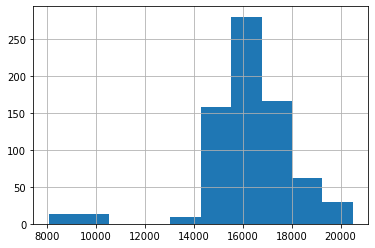

In [78]:
# CA journalier
ca_date = df.resample('D',on='date')['price'].sum().reset_index()
display(ca_date['price'].hist())
display(ca_date['price'].describe())
display(ca_date)

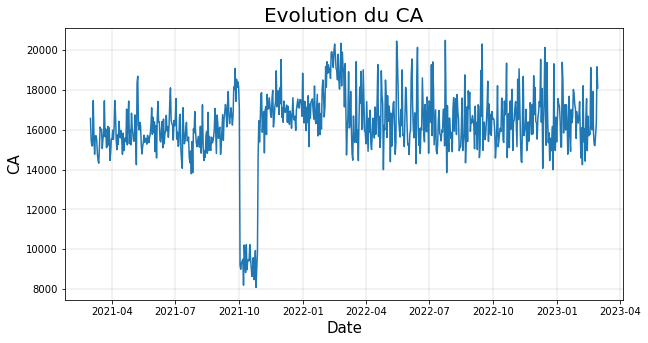

In [79]:
# Graphique montrant l'évolution du CA
plt.figure(figsize=(10,5))

ax = sns.lineplot(x=ca_date.date, y=ca_date.price)

ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("CA", fontsize = 15)
ax.grid(b=True, which='major', color='black', linewidth=0.1)
ax.grid(b=True, which='minor', color='black', linewidth=0.075)
plt.title("Evolution du CA",fontsize=20)
plt.show()

**Observation**: 
Nous observons une fluctuation journalière du CA et nous observons une chute du CA vers octobre 2021 et une période élevée du CA en février/ mars 2022. 

### Décomposition en moyenne mobile du CA

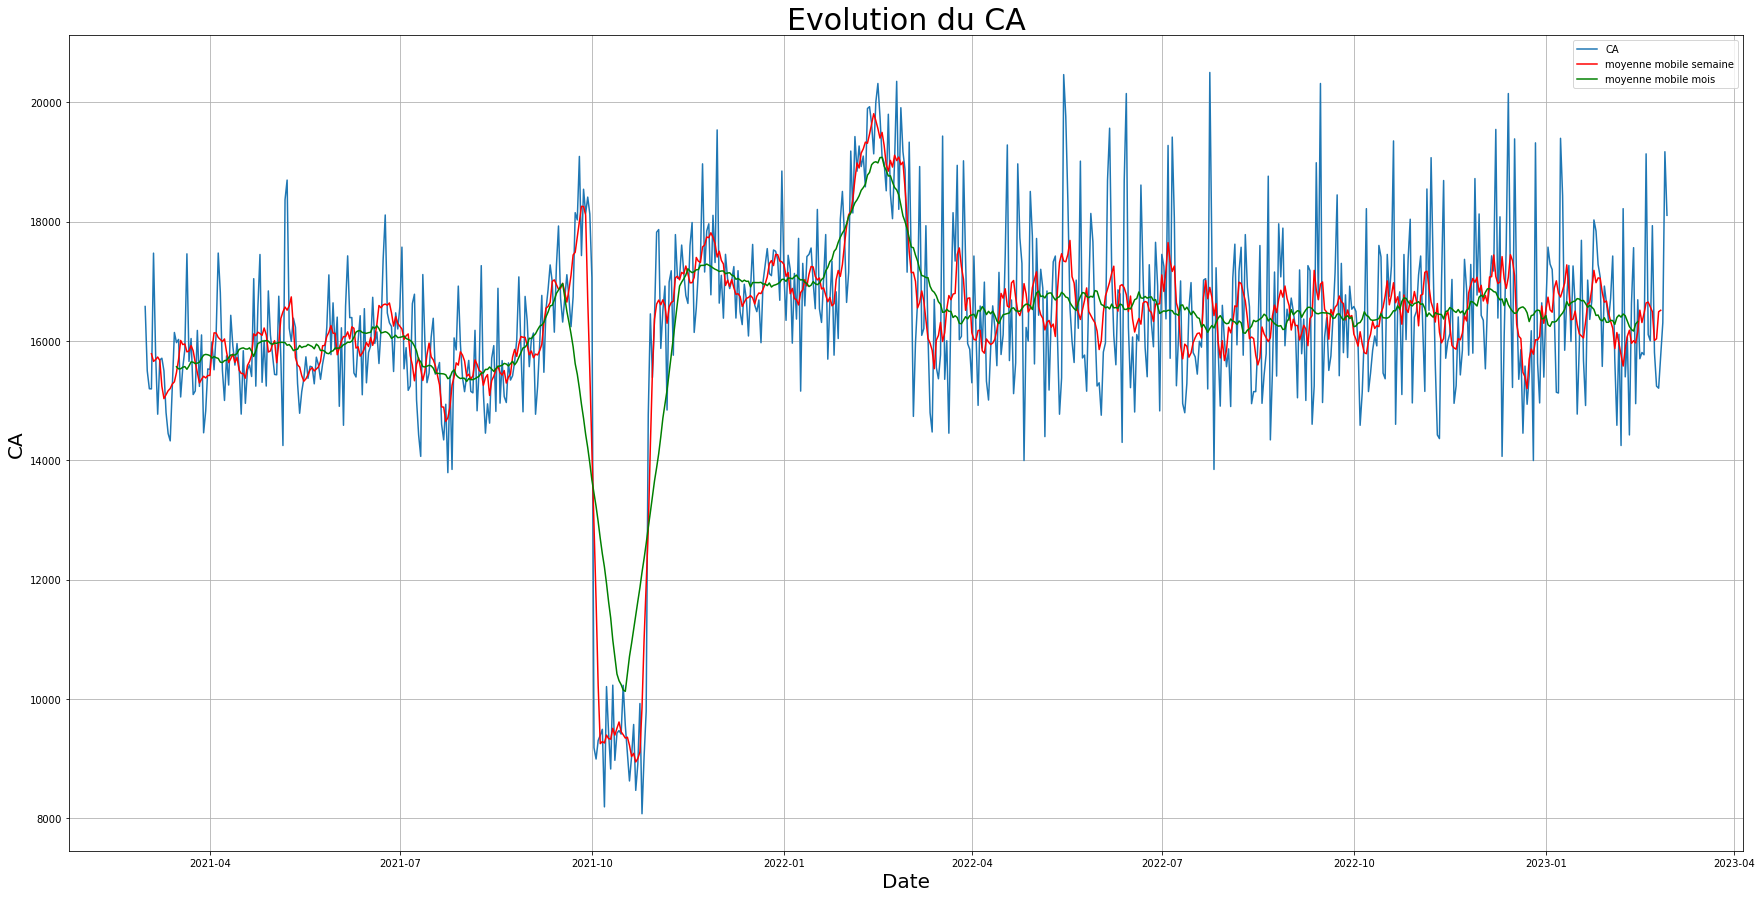

In [80]:
ca_date['week_rolling_avg']= ca_date.price.rolling(7,center=True).mean()
ca_date['month_rolling_avg']= ca_date.price.rolling(30,center=True).mean()

date = ca_date['date']
ca = ca_date['price']
rolling_avg_week = ca_date['week_rolling_avg']
rolling_avg_month= ca_date['month_rolling_avg']

plt.figure(figsize=(30,15))
plt.plot(date, ca, label='CA')
plt.plot(date, rolling_avg_week, color='red', label='moyenne mobile semaine')
plt.plot(date, rolling_avg_month, color='green', label='moyenne mobile mois')
plt.legend()

plt.title("Evolution du CA",fontsize=30)
plt.xlabel("Date", fontsize = 20)
plt.ylabel("CA", fontsize = 20)
plt.grid()
plt.show()

### Exploration de la chute : suppression de la periode de chute

In [81]:
# Déterminer la date des chutes: CA en dessous de 10000 par jour. 
date_chute = ca_date.loc[ca_date['price']<10000]
startDate = date_chute['date'].min()
endDate = date_chute['date'].max()
# Dataframe des transactions pendant la période de la chute du CA
date_chute = (df['date']>=startDate) & (df['date']<=endDate)
df_chute = df.loc[date_chute]
df_chute 

,client_id,sex,birth,id_prod,date,session_id,price,categ,age
13,c_2809,m,1981,0_1316,2021-10-26 22:32:35.603105,s_110587,7.20,0,40
14,c_1987,f,1972,0_1316,2021-10-16 08:23:19.617907,s_105529,7.20,0,49
39,c_2993,m,1964,0_1316,2021-10-20 07:52:27.027746,s_107468,7.20,0,57
51,c_5835,f,1991,0_1316,2021-10-22 23:44:43.991791,s_108696,7.20,0,30
52,c_6096,f,1966,0_1316,2021-10-26 09:25:30.899125,s_110348,7.20,0,55
...,...,...,...,...,...,...,...,...,...
679224,c_4394,f,1978,0_1595,2021-10-03 18:06:24.864280,s_99495,2.99,0,43
679229,c_2496,m,1958,0_1776,2021-10-04 21:13:09.706161,s_100046,21.16,0,63
679234,c_6597,f,1974,0_1331,2021-10-08 20:38:43.719048,s_101952,29.99,0,47
679244,c_8374,m,1963,0_79,2021-10-18 01:34:47.976618,s_106386,24.99,0,58


In [82]:
# Nombre de ventes par catégorie pendant la chute
df_chute.groupby('categ').size()

categ
0    15336
2      923
dtype: int64

**Observation:**
Pendant la chute, il n'y a pas eu de vente de la catégorie '1' 

In [83]:
# Période hors chute retire du dataframe
df = df.loc[~date_chute]

## Analyse des produits vendus
### Répartition du CA par référence produit

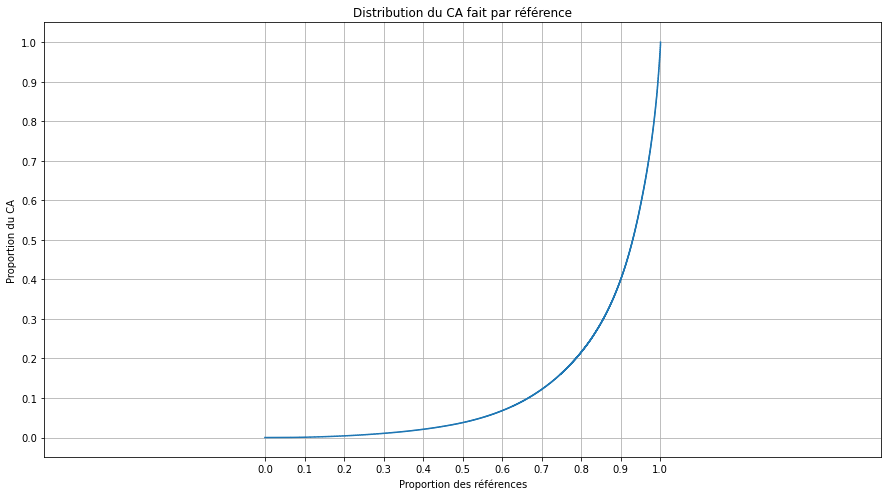

Indice de gini: 0.7442017750282106


In [84]:
# Courbe de Lorenz pour voir la répartition du CA par référence
ca_produit = df.groupby(['id_prod','categ'],as_index=False)[['price']].sum().sort_values("price", ascending=False)
ca = ca_produit['price']

n = len(ca)

lorenz = np.cumsum(np.sort(ca))/ca.sum()
lorenz = np.append([0],lorenz)
plt.figure(figsize=(15,8))
plt.axes().axis('equal')
xaxis  = np.linspace(0-1/n, 1+1/n, n+1)

plt.plot(xaxis,lorenz, drawstyle='steps-post')
plt.title('Distribution du CA fait par référence')
plt.xlabel('Proportion des références')
plt.ylabel('Proportion du CA')
plt.grid()
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC
gini = 2*S
print(f"Indice de gini: {gini}")

**Obsevation:**
Nous pouvons estimer que 50% des articles font 5% du CA pendant que l'autre 50% font 95% du chiffre d'affaire. Nous observons aussi que 20% des références font 80% du CA, qui montre l'effet Pareto (20 % des causes sont responsables de 80 % des effets). L'indice de gini montre une forte inégalité entre les CA des références. 

### Les top et les flop de produit par rapport au CA

In [85]:
# Les id_product qui ont fait le plus et le moins de chiffre d'affaire sur les 2 dernières années
ca_produit = df.groupby(['id_prod','categ'],as_index=False)[['price']].sum().sort_values("price", ascending=False)
# Top CA
print('Les références qui ont fait le plus de CA')
display(ca_produit.head(10))
# Flop CA
print('Les références qui ont fait le moins de CA')
display(ca_produit.tail(10))

Les références qui ont fait le plus de CA


,id_prod,categ,price
3095,2_159,2,92703.65
3069,2_135,2,67817.17
3044,2_112,2,63245.52
3033,2_102,2,59317.42
3151,2_209,2,55712.04
2618,1_395,1,54356.25
2590,1_369,1,54025.48
3042,2_110,2,52227.75
2640,1_414,1,51949.40
3200,2_39,2,51553.11


Les références qui ont fait le moins de CA


,id_prod,categ,price
1543,0_324,0,2.36
801,0_1728,0,2.27
664,0_1601,0,1.99
1783,0_541,0,1.99
2078,0_807,0,1.99
1896,0_643,0,1.98
718,0_1653,0,1.98
313,0_1284,0,1.38
2178,0_898,0,1.27
594,0_1539,0,0.99


**Observation**: 
Les tops viennent des catégories '2' et '1' tandis que tous les 10 flops viennent de la catégorie '0'

### Répartition des nombres de ventes par référence produit

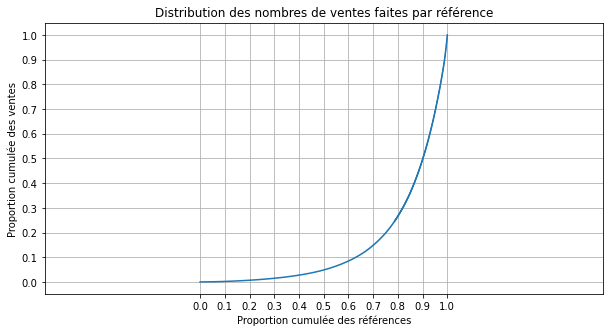

Indice de gigi: 0.6946589298251933


In [86]:
# Courbe de Lorenz pour voir la répartition du CA par référence
ventes_produits = df.groupby(['id_prod'],as_index=False).agg(nombre_vente=('session_id','count'),
                                                   categ=('categ','min') 
                                                            ).sort_values('nombre_vente')

n_vente = ventes_produits['nombre_vente']

n = len(n_vente)

lorenz = np.cumsum(np.sort(n_vente))/n_vente.sum()
lorenz = np.append([0],lorenz)
plt.figure(figsize=(10,5))
plt.axes().axis('equal')
xaxis  = np.linspace(0-1/n, 1+1/n, n+1)

plt.plot(xaxis, lorenz, drawstyle='steps-post')
plt.title('Distribution des nombres de ventes faites par référence')
plt.xlabel('Proportion cumulée des références')
plt.ylabel('Proportion cumulée des ventes')
plt.grid()
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n 
S = 0.5 - AUC
gini = 2*S
print(f"Indice de gigi: {gini}")

**Obsevation**:
Nous pouvons estimer que 50% des articles font 5% des ventes pendant que l'autre 50% font 95% des ventes. Ce qui montre une préfèrence significative pour certains articles. 10% des articles font 50% des ventes. L'indice de gini nous indique une forte inégalité entre les nombres de ventes des références. 

In [87]:
# Top en nombre de ventes
print('Les références qui ont fait le plus grand nombre de ventes')
display(ventes_produits.tail(10))
# Flop en nombre de ventes
print('Les références qui ont fait le plus faible nombres de ventes')
display(ventes_produits.head(10))

Les références qui ont fait le plus grand nombre de ventes


,id_prod,nombre_vente,categ
2632,1_407,1935,1
2631,1_406,1939,1
2639,1_413,1945,1
2638,1_412,1951,1
2628,1_403,1960,1
2652,1_425,2096,1
2732,1_498,2128,1
2640,1_414,2180,1
2643,1_417,2189,1
2590,1_369,2252,1


Les références qui ont fait le plus faible nombres de ventes


,id_prod,nombre_vente,categ
801,0_1728,1,0
166,0_1151,1,0
2178,0_898,1,0
697,0_1633,1,0
664,0_1601,1,0
2107,0_833,1,0
656,0_1595,1,0
751,0_1683,1,0
2165,0_886,1,0
3174,2_23,1,2


**Observation**:
En temps que nombre de ventes, les références tops viennent de la catégorie 1 seulement, tandis que les flops viennent des catégories 0 et 2.

### Répartition des CA des références par catégories

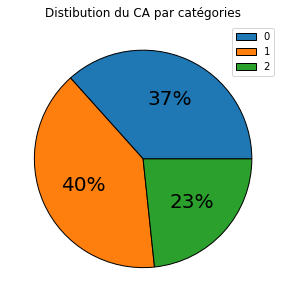

In [88]:
# CA par catégories
ca_cat = df.groupby('categ')['price'].sum().reset_index()
data = ca_cat['price']
labels = ca_cat['categ']

plt.figure(figsize=(5,5))
plt.pie(data, autopct='%.0f%%', 
        textprops= {'fontsize':20}, 
        wedgeprops={'edgecolor':"k",'linewidth':1,'linestyle':'solid'})

plt.title("Distibution du CA par catégories")
plt.legend( loc=1, labels=labels)
plt.show()

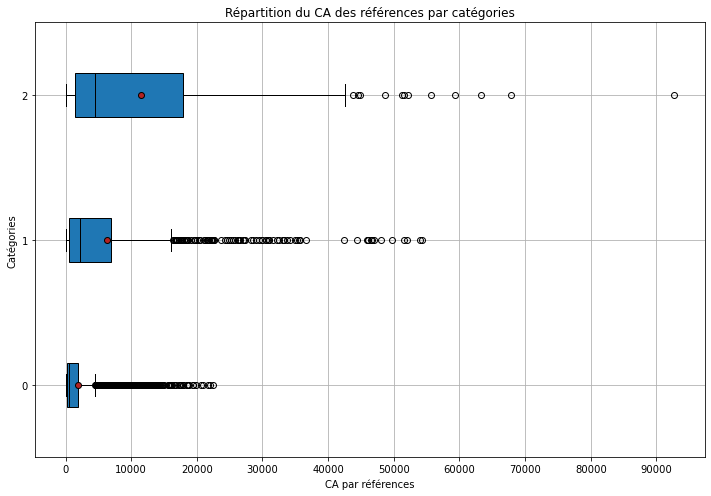

In [89]:
# Distribution des ca des références par catégories
df_ca_cat = df.groupby('id_prod', as_index=False).agg( ca=('price','sum'),
                         categ=('categ','min') )


X = "categ"
Y = "ca"

modalities = df_ca_cat[X].unique()
groupes = []

for m in modalities:
    groupes.append(df_ca_cat[df_ca_cat[X]==m][Y])

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(12,8))
plt.boxplot(groupes, labels=modalities, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title('Répartition du CA des références par catégories')
plt.xlabel('CA par références')
plt.ylabel('Catégories')
plt.xticks([0,10000,20000,30000,40000,50000,60000,70000,80000,90000])
plt.grid()
plt.show()

**Question**:
Est ce qu'il y a une différence de moyenne de CA entre les trois catégories de livres ?

**Hypothèse**: 
* Hypothèse H0: Les trois catégories ont des moyennes égales
* H1: Les trois catégories ont des moyennes différentes 

**Variable**: 
* Variable d'étude: Catégories, variable qualitative(3 groupes), indépendant 
* Variable de réponse: CA, variable quantitatives

**Test utilisé**: 
ANOVA, Analyse de la variance (paramétrique) ou Kruskal-Wallis( non-paramétrique)

ANOVA conditions: 
- Mesures sont indépendantes ☑
- Echantillons ont des variance égales - A tester
- Résidus suivent une distribution normale - A tester
- Au moins 20 individus dans le dispositif ☑

Conditions non remplies => Kruskal-Wallis

In [90]:
# Création d'échantillons
categ_0 = df_ca_cat['ca'].loc[df_ca_cat['categ']=='0'].to_numpy()
categ_1 = df_ca_cat['ca'].loc[df_ca_cat['categ']=='1'].to_numpy()
categ_2 = df_ca_cat['ca'].loc[df_ca_cat['categ']=='2'].to_numpy()

In [91]:
# Test de Normalite
stat, p_value = scipy.stats.kstest(categ_0,'norm')
print(f"normaltest categ_0: {stat}")
print(f"P-value: {p_value}")
TestNormalité(p_value)

stat, p_value = scipy.stats.kstest(categ_1,'norm')
print(f"normaltest categ_1: {stat}")
print(f"P-value: {p_value}")
TestNormalité(p_value)

stat, p_value = scipy.stats.kstest(categ_2,'norm')
print(f"normaltest categ_2: {stat}")
print(f"P-value: {p_value}")
TestNormalité(p_value)

normaltest categ_0: 0.9932731138693414
P-value: 0.0
 Nous pouvons estimer que l'échantillon ne suit pas une distribution Normale
normaltest categ_1: 1.0
P-value: 0.0
 Nous pouvons estimer que l'échantillon ne suit pas une distribution Normale
normaltest categ_2: 1.0
P-value: 0.0
 Nous pouvons estimer que l'échantillon ne suit pas une distribution Normale


In [92]:
# Test de variance
stat, p_value = scipy.stats.bartlett(categ_0, categ_1, categ_2)
print(f"Bartlett's test statistic: {stat}")
print(f"P-value: {p_value}")
TestVariance(p_value)

Bartlett's test statistic: 2350.6131449036293
P-value: 0.0
 La variance des échantillons n'est pas égale


In [93]:
# Test de Kruskal-Wallis
stat, p_value = scipy.stats.kruskal(categ_0, categ_1, categ_2)
print(f"Kruskal-Wallis Test: {stat}")
print(f"P-value: {p_value}")
TestStat(p_value)

Kruskal-Wallis Test: 474.96901568361886
P-value: 7.274258107968699e-104
 L'hypothèse null (H0) est rejetée


**Conclusion**:
Les trois catégories ont des moyennes de CA différentes. Cela peut être dû au fait que certains groupes se vendent plus qu'un autre mais aussi parce que les trois groupes n'ont pas la même distribution de prix d'articles. 

### Répartition des reférences par catégories

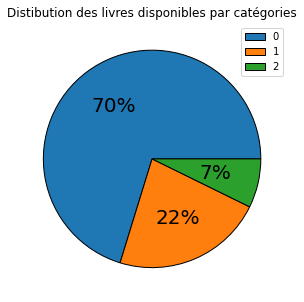

In [95]:
# Répartition des références disponibles par catégories
repation_ref_dispo = product.groupby('categ')['id_prod'].count().reset_index()
repation_ref_dispo['proportion_ref_dispo']=repation_ref_dispo['id_prod']/repation_ref_dispo['id_prod'].sum()

data = repation_ref_dispo['proportion_ref_dispo']
labels = repation_ref_dispo['categ']

plt.figure(figsize=(5,5))
plt.pie(data, autopct='%.0f%%', 
        textprops= {'fontsize':20}, 
        wedgeprops={'edgecolor':"k",'linewidth':1,'linestyle':'solid'})

plt.title("Distibution des livres disponibles par catégories")
plt.legend( loc=1, labels=labels)
plt.show()

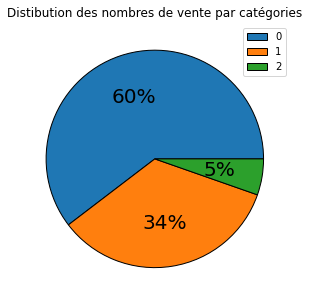

In [96]:
# Répartition des références vendues par catégories
id_prod_categ = df.groupby('categ',as_index=False)['id_prod'].count()
id_prod_categ['proportion_categ_vendu']=id_prod_categ['id_prod']/id_prod_categ['id_prod'].sum()

data = id_prod_categ['id_prod']
labels = id_prod_categ['categ']

plt.figure(figsize=(5,5))
plt.pie(data, autopct='%.0f%%', 
        textprops= {'fontsize':20}, 
        wedgeprops={'edgecolor':"k",'linewidth':1,'linestyle':'solid'})

plt.title("Distibution des nombres de vente par catégories")
plt.legend( loc=1, labels=labels)
plt.show()

**Observation**: Nous observons que le nombre de 'id_produit' par catégories n'est pas équitable. Il y a beaucoup de catégories '0' vendus mais c'est aussi celui qui a le plus d'article disponible. Le nombre de vente supérieur de la catégorie '0' ne serait peut-être pas dû à sa popularité, mais à la quantité d'article de cette catégorie disponible.  

**Question**: 
Est ce qu'il y a un lien entre la répartitions des ventes par catégorie et la répartition des références disponibles par catégorie ?

**Hypothèse**:
* H0: Proportion des ventes par catégories (proportion observée) sont égales aux proportions des références disponibles par catégories( proportion théorique).
* H1: Les proportions ne seront pas égales

**Test à faire**:
Test pour une proportion: khi²

In [97]:
# Tableau des proportions
id_prod_categ['proportion_ref_dispo'] = repation_ref_dispo['proportion_ref_dispo']
id_prod_categ

,categ,id_prod,proportion_categ_vendu,proportion_ref_dispo
0,0,400344,0.603771,0.702464
1,1,227169,0.342600,0.224825
2,2,35560,0.053629,0.072711


In [98]:
# Test Chi2
stat, p = scipy.stats.chisquare(id_prod_categ['proportion_categ_vendu'],id_prod_categ['proportion_ref_dispo'])
print(f"chi2 Test:{stat}")
print(f"P-value:{p}")
TestStat(p)

chi2 Test:0.08057057048328155
P-value:0.9605153791994975
 L'hypothèse null (H0) peut être acceptée


**Conclusion**:
Les proportions des catégories vendues sont identiques aux proportions des catégories disponibles. Donc nous pourrions hypotéthiser que la quantité de livres vendue de chaque catégorie est influencée par la quantité de livres disponibles de chaque catégorie. 

## Analyse des clients
### Répartition du CA entre clients (courbe de Lorenz)

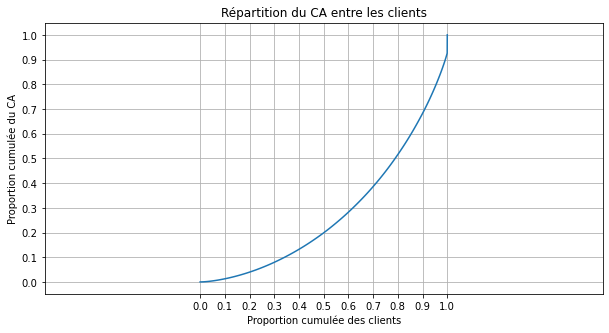

Indice de gini: 0.446724787559757


In [99]:
# Courbe de Lorenz

depense_client = df.groupby('client_id')['price'].sum().reset_index()
depense_client.sort_values('price', ascending= False)

ca = depense_client['price']

n = len(ca)

lorenz = np.cumsum(np.sort(ca))/ca.sum()
lorenz = np.append([0],lorenz)
plt.figure(figsize=(10,5))
plt.axes().axis('equal')
xaxis  = np.linspace(0-1/n,1+1/n,n+1)

plt.plot(xaxis,lorenz, drawstyle='steps-post')
plt.title('Répartition du CA entre les clients')

plt.xlabel('Proportion cumulée des clients')
plt.ylabel('Proportion cumulée du CA')
plt.grid()
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.show()

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC # surface entre la première bissectrice et le courbe de Lorenz
gini = 2*S
print(f"Indice de gini: {gini}")

**Observation**:
50 % des clients font 20% du CA pendant que l'autre 50% des clients font 80% du CA. L'indice de Gini étant loin de 0, nous pouvons conclure qu'il n'y a pas une bonne équité entre les clients lambdas.

### Analyse par genre de clients

In [101]:
# Nombre de visite par genre
df_session = df.groupby('session_id',as_index=False).agg( client_id=('client_id','min'),
                                                         genre=('sex','min'),
                                                         age=('age','min'),
                                                         date_transaction=('date','min'),
                                                         ca=('price','sum') )
df_session.groupby('genre').size()

genre
f    165156
m    168291
dtype: int64

In [102]:
# Nombre de clients par genre
df_client = df.groupby('client_id',as_index=False).agg(genre=('sex','min'),
                                                         ca=('price','sum') )
df_client.groupby('genre').size()

genre
f    4478
m    4121
dtype: int64

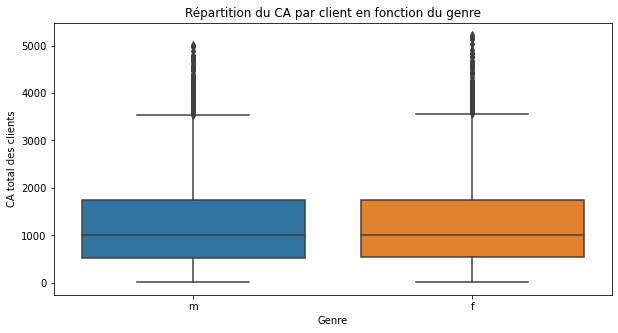

In [111]:
# CA par sexe
df_client = df.groupby('client_id',as_index=False).agg(genre=('sex','min'),
                                                         ca=('price','sum') )
plt.figure(figsize=(10,5))
# suppression des outliers identifie precedement
df_client= df_client[df_client['ca']<50000]

sns.boxplot(x=df_client['genre'], y=df_client['ca'])

plt.title('Répartition du CA par client en fonction du genre')
plt.xlabel('Genre')
plt.ylabel('CA total des clients')
plt.show()

**Question: Est ce qu'il y a une différence CA entre les hommes et les femmes ?**

**Hypothèse**:
* Hypothèse H0: Pas de différence de CA entre homme et femme
* Hypothèse H1: Le CA est dépendant du genre des clients

**Variable**:
Variable d'étude: Genre, variable qualitative(2 groupes), indépendant
Variable de réponse: CA, variable quantitatives

**Test utilisé**:
1) Comparaison des distribution: Kolmogorov-Smirnov


2) Test des moyennes :T-test de student (paramétrique) ou Mann-Whitney ( non-paramétrique)
* Variance égale(Test de bartlett)=> T-test de student
* Variance non-égale => Mann-Whitney

T-test de student: 
- Mesures sont indépendantes ☑
- Echantillons ont des variance égales - A tester
- Au moins 20 individus dans le dispositif ou normalité des population supposée ou vérifiée ☑

Conditions non remplies => Mann-Whitney


In [112]:
# Création des échantillons
ca_m = df_client[df_client['genre']=='m']['ca'].to_numpy()
ca_f = df_client[df_client['genre']=='f']['ca'].to_numpy()

In [113]:
# 1) Comparaison des distribution: Kolmogorov-Smirnov
stat, p_value = scipy.stats.kstest(ca_m,ca_f)
print(f"Kolmogorov-Smirnov: {stat}")
print(f"P-value: {p_value}")
TestStat(p_value)

Kolmogorov-Smirnov: 0.009485587281516461
P-value: 0.9891545820946857
 L'hypothèse null (H0) peut être acceptée


In [114]:
# 2) Test des moyennes
# Test de variance
stat, p_value = scipy.stats.bartlett(ca_m, ca_f)
print(f"Bartlett's test statistic: {stat}")
print(f"P-value: {p_value}")
TestVariance(p_value)

Bartlett's test statistic: 0.5533730393366626
P-value: 0.45694273805400554
 La variance est égale entre les deux échantillons


##### Les échantillons ont une variance égale, donc nous pouvons faire un test de Student

In [115]:
# Test de moyenne
stat, p_value = scipy.stats.ttest_ind(ca_m,ca_f)
print(f"Test de Student: {stat}")
print(f"P-value: {p_value}")
TestStat(p_value)

Test de Student: 0.14882383259887086
P-value: 0.8816961366199914
 L'hypothèse null (H0) peut être acceptée


**Conclusion**:
Les deux échantillons on des moyennes égales et ont une distribution similaire. Nous pouvons estimer qu'il n'y a pas de différences significatives de dépenses entre les hommes et les femmes. 

### Analyse des 'age' des clients

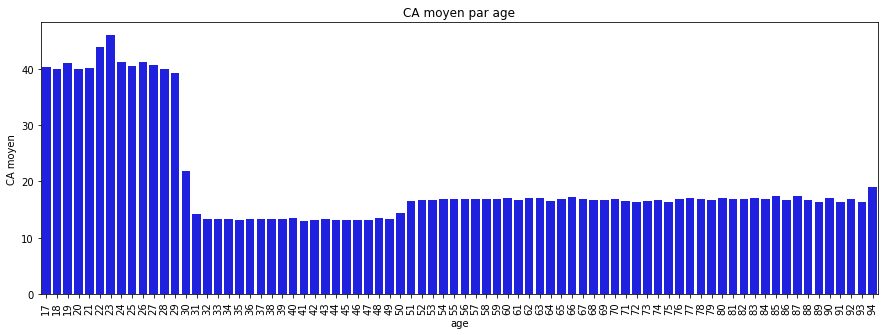

In [117]:
# CA moyen par produit par age
ca_age = df.groupby('age').agg(ca_total = ('price','sum'), 
                               nombre_par_age = ('age','count')).reset_index()
ca_age['CA moyen']= ca_age['ca_total']/ca_age['nombre_par_age']

# Barplot des CA moyens par age
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=ca_age['age'], y= ca_age['CA moyen'],color='blue')

ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title('CA moyen par age')
plt.show()

In [118]:
# Regrouper la variable age en trois groupes
labels= ["17-30", "31-50", "50+"]
df['AgeGroup'] = pd.cut(df['age'], [17, 30, 50, 100], labels=labels, include_lowest=True)

### Autres information utiles

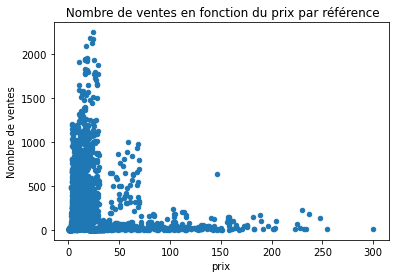

In [119]:
# Nombre de vente en fonction du prix de produit
nombre_vente_price = df.groupby(['id_prod','price'])['session_id'].count().reset_index()
nombre_vente_price.plot.scatter(x='price', y='session_id')

plt.title(' Nombre de ventes en fonction du prix par référence')
plt.xlabel('prix')
plt.ylabel('Nombre de ventes')

plt.show()

**Observation:**
Le prix d'un produit ne semble pas avoir une influence sur le nombre de ventes. Nous avons une clientèle qui a tendance à acheter des articles à petits prix.


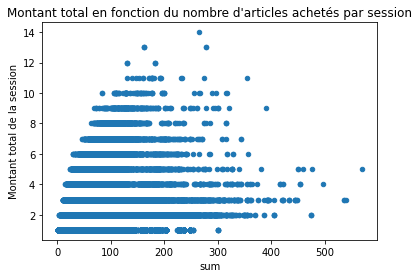

In [120]:
# CA par session vs nombre d'articles par session
ca_taille = df.groupby(['session_id'])['price'].agg(['sum', len]).reset_index()
ca_taille.plot.scatter(x='sum', y='len')

plt.title("Montant total en fonction du nombre d'articles achetés par session")
plt.ylabel("Nombre d'articles")
plt.ylabel("Montant total de la session")
plt.show()

**Observation**: 
Nous n'observons pas de relation évidente entre le nombre d'articles achetés et le montant total de la session.

In [121]:
# Enregistrement des changements faits à la dataframe 'df' en csv pour être utilisés pour la derniere partie
df.to_csv('df2.csv')